In [1]:
import math
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import jax.scipy as jsp
from jax import jit, lax
jax.config.update("jax_enable_x64", True)

key_master = jax.random.PRNGKey(0)


Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/n/home12/isanchez/.conda/envs/itzeljax/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/n/home12/isanchez/.conda/envs/itzeljax/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


In [ ]:
# HH channel + gating utilities
SAFE_Z   = 1e-4
EXP_CLIP = 60.0

def safe_exp(x):
    return jnp.exp(jnp.clip(x, -EXP_CLIP, EXP_CLIP))

def vtrap(dx, k):
    z = dx / k
    taylor = 1.0 - z/2.0 + (z*z)/12.0 - (z**4)/720.0
    return jnp.where(jnp.abs(z) < SAFE_Z, k * taylor, dx / jnp.expm1(z))

# classic HH rates (v in mV, t in ms)
def alpha_m(v): return 0.1  * vtrap(25.0 - v, 10.0)
def beta_m(v):  return 4.0  * safe_exp(-v / 18.0)
def alpha_h(v): return 0.07 * safe_exp(-v / 20.0)
def beta_h(v):  return 1.0  / (safe_exp((30.0 - v)/10.0) + 1.0)
def alpha_n(v): return 0.01 * vtrap(10.0 - v, 10.0)
def beta_n(v):  return 0.125 * safe_exp(-v / 80.0)

def x_inf(alpha_fn, beta_fn, v):
    """Steady-state gate value at voltage v"""
    a, b = alpha_fn(v), beta_fn(v)
    return a / (a + b + 1e-12)

def gate_update(x, a, b, dt_ms):
    """
    Rush–Larsen update for gate x given rates a(v), b(v) and time step dt_ms (ms)
    """
    inv_tau = a + b
    tau = 1.0 / jnp.maximum(inv_tau, 1e-12)  # ms
    x_ss = a * tau # steady state
    return jnp.clip(x_ss - (x_ss - x) * jnp.exp(-dt_ms / tau), 0.0, 1.0)


# Axial coupling matrix (cable)
def build_tridiagonal_gax(n_comp, g_link):
    """
    Build axial conductance matrix Gax for a 1D cable with n_comp compartments
    and uniform coupling g_link between neighbors.
    """
    G = jnp.zeros((n_comp, n_comp))
    idx = jnp.arange(n_comp - 1)
    # neighbor couplings
    G = G.at[idx,   idx+1].set(-g_link)
    G = G.at[idx+1, idx  ].set(-g_link)
    # diagonal terms are minus row sums
    G = G.at[jnp.arange(n_comp), jnp.arange(n_comp)].set(-jnp.sum(G, axis=1))
    return G  # symmetric PSD

# One implicit HH cable step
@jit
def hh_step_cable(state, I_inj_vec, params, dt_ms, Gax):
    """
    Single time step for HH cable with implicit Euler on V and
    Rush–Larsen for gates.
    """
    v, m, h, n = state

    # channel rates at V_t
    am, bm = alpha_m(v), beta_m(v)
    ah, bh = alpha_h(v), beta_h(v)
    an, bn = alpha_n(v), beta_n(v)

    # Rush–Larsen gates -> t+1
    m_new = gate_update(m, am, bm, dt_ms)
    h_new = gate_update(h, ah, bh, dt_ms)
    n_new = gate_update(n, an, bn, dt_ms)

    # channel parameters
    gNa, gK, gL = params["HH_gNa"], params["HH_gK"], params["HH_gL"]
    ENa, EK, EL = params["HH_ENa"], params["HH_EK"], params["HH_EL"]
    Cm = params["C_m"]

    # effective ionic conductances at t+1
    gNa_eff = gNa * (m_new**3) * h_new
    gK_eff  = gK  * (n_new**4)
    gion = gNa_eff + gK_eff + gL            # (N,)
    Irev = gNa_eff*ENa + gK_eff*EK + gL*EL  # (N,)

    # implicit Euler for V:
    # (C/dt I + diag(gion) + Gax) v_{t+1} = (C/dt) v_t + Irev + I_inj
    A = jnp.diag(Cm / dt_ms + gion) + Gax
    b = (Cm / dt_ms) * v + Irev + I_inj_vec
    v_new = jsp.linalg.solve(A, b)

    return (v_new, m_new, h_new, n_new), v_new

def integrate_cable(state0, currents, params, dt_ms, Gax):
    """
    Integrate HH cable dynamics over time.
    """
    def step(carry, I_t):
        return hh_step_cable(carry, I_t, params, dt_ms, Gax)

    final_state, v_trace = lax.scan(step, state0, currents)
    return final_state, v_trace

In [ ]:
class MultiCompHH:
    def __init__(self, n_comp=5, g_link=0.2):
        self.n_comp = n_comp
        self.g_link = g_link

        # Default HH parameters (per compartment)
        self.params = {
            "HH_gNa": 120.0 * jnp.ones(n_comp),
            "HH_gK": 36.0 * jnp.ones(n_comp),
            "HH_gL": 0.3 * jnp.ones(n_comp),
            "HH_ENa": 50.0 * jnp.ones(n_comp),
            "HH_EK": -77.0 * jnp.ones(n_comp),
            "HH_EL": -54.387 * jnp.ones(n_comp),
            "C_m": 1.0 * jnp.ones(n_comp),
        }

        self.Gax = build_tridiagonal_gax(n_comp, g_link)

    def init_state(self, phys_params):
        """
        Initialize v, m, h, n at t=0
        v0 at leak reversal, gates at steady state for v0.
        """
        v0 = phys_params["HH_EL"]  # (N,) mV
        m0 = x_inf(alpha_m, beta_m, v0)
        h0 = x_inf(alpha_h, beta_h, v0)
        n0 = x_inf(alpha_n, beta_n, v0)
        return (v0, m0, h0, n0)

    def simulate(self, phys_params, currents, dt_ms=0.025):
        """
        Simulate the multi-compartment neuron.
        """
        state0 = self.init_state(phys_params)
        _, V = integrate_cable(state0, currents, phys_params, dt_ms, self.Gax)
        return V

In [4]:
N = 5
dt = 0.025
t_max = 50.0
T = int(math.ceil(t_max / dt))

model = MultiCompHH(n_comp=N, g_link=0.2)
phys_true = model.params  # baseline/teacher physical parameters


In [ ]:
def make_step_injection(T, n_comp, dt, comp_idx, delay, dur, amp):
    """
    Step current into compartment comp_idx.
    """
    I = jnp.zeros((T, n_comp))
    start = int(jnp.round(delay / dt))
    end = int(jnp.round((delay + dur) / dt))
    start = jnp.clip(start, 0, T)
    end = jnp.clip(end, 0, T)
    idx = jnp.arange(start, end)
    I = I.at[idx, comp_idx].set(amp)
    return I


HYPERPARAMETER SWEEP

In [6]:
def sweep_amp(
    amp_list,
    g_link=0.2,
    N=5,
    dt_ms=0.025,
    t_max_ms=50.0,
    delay_ms=5.0,
    dur_ms=20.0,
    soma_idx=0,
    proximal_idx = 1,
):
    T = int(math.ceil(t_max_ms / dt_ms))
    time = jnp.arange(T) * dt_ms
    distal_idx = N - 1

    fig, axes = plt.subplots(len(amp_list), 1,
                             figsize=(7, 3 * len(amp_list)),
                             sharex=True)
    if len(amp_list) == 1:
        axes = [axes]

    for ax, amp in zip(axes, amp_list):
        model = MultiCompHH(n_comp=N, g_link=g_link)
        phys = model.params

        I = make_step_injection(T, N, dt_ms, soma_idx, delay_ms, dur_ms, amp)
        V = model.simulate(phys, I, dt_ms)  # (T, N)

        ax.plot(time, V[:, soma_idx], label=f"soma ({soma_idx})")
        ax.plot(time, V[:, proximal_idx], "--", label=f"proximal ({proximal_idx})")
        ax.plot(time, V[:, distal_idx], "--", label=f"distal ({distal_idx})")
        ax.set_ylabel("V (mV)")
        ax.set_title(f"amp = {amp}, g_link = {g_link}")
        ax.legend(loc="best")

    axes[-1].set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()


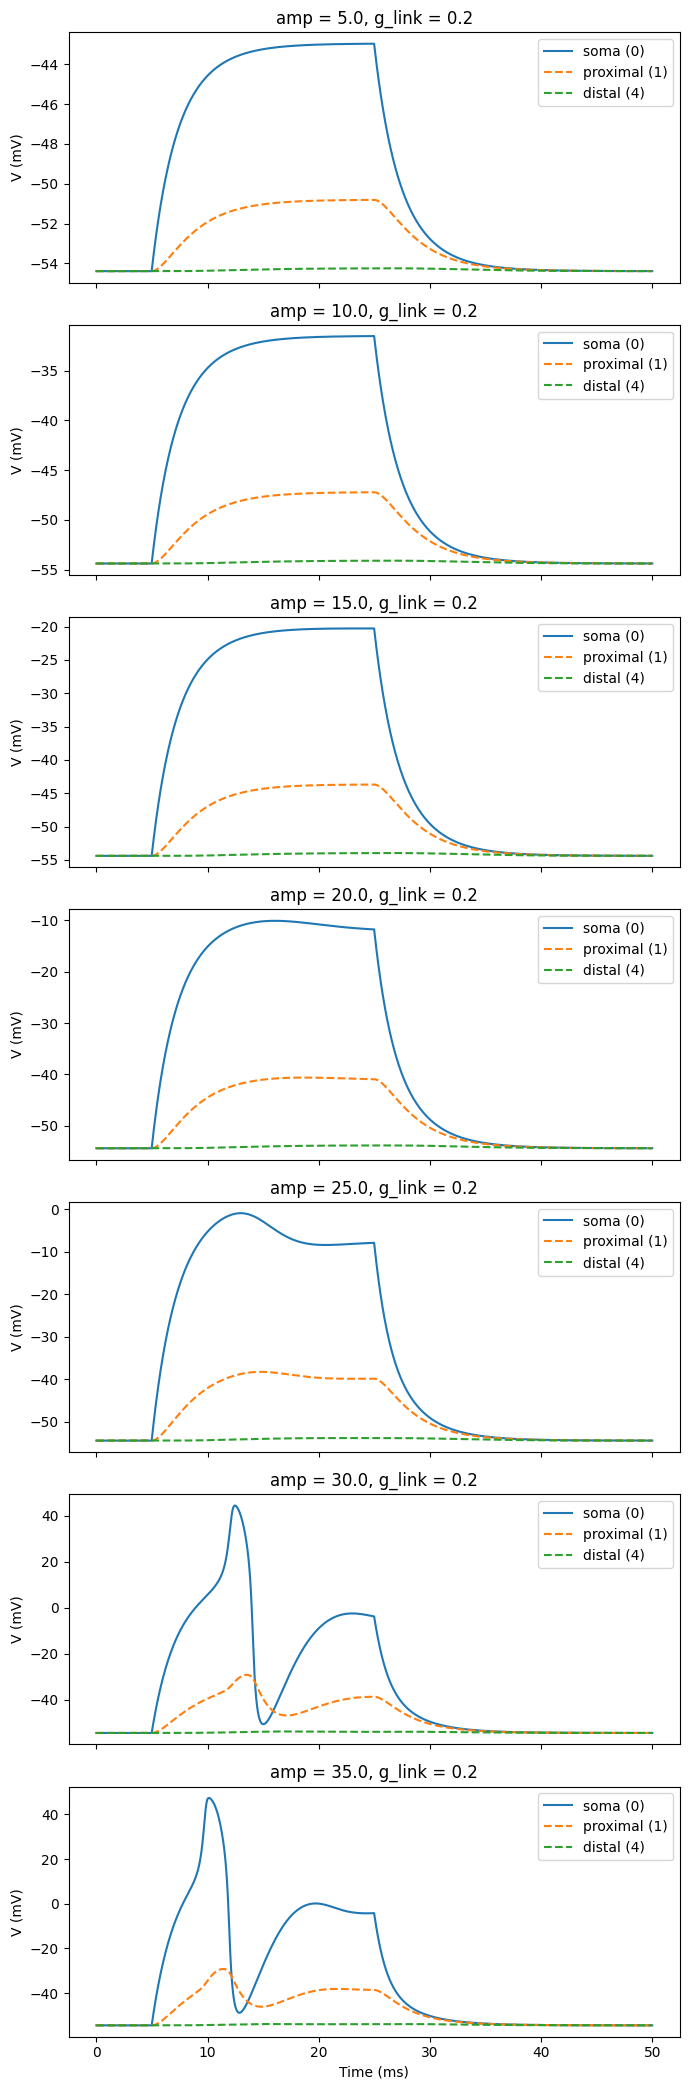

In [7]:
amp_list = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0]
sweep_amp(amp_list, g_link=0.2, N=N, dt_ms=dt, t_max_ms=t_max)


In [8]:
def sweep_g_link(
    g_link_list,
    amp,
    N=5,
    dt_ms=0.025,
    t_max_ms=50.0,
    delay_ms=5.0,
    dur_ms=20.0,
    soma_idx=0,
    proximal_idx=1,
):
    T    = int(math.ceil(t_max_ms / dt_ms))
    time = jnp.arange(T) * dt_ms
    distal_idx = N - 1

    fig, axes = plt.subplots(len(g_link_list), 1,
                             figsize=(7, 3 * len(g_link_list)),
                             sharex=True)
    if len(g_link_list) == 1:
        axes = [axes]

    for ax, g_link in zip(axes, g_link_list):
        model = MultiCompHH(n_comp=N, g_link=g_link)
        phys  = model.params

        I = make_step_injection(T, N, dt_ms, soma_idx, delay_ms, dur_ms, amp)
        V = model.simulate(phys, I, dt_ms)

        ax.plot(time, V[:, soma_idx], label=f"soma ({soma_idx})")
        ax.plot(time, V[:, proximal_idx], "--", label=f"proximal ({proximal_idx})")
        ax.plot(time, V[:, distal_idx], ":", label=f"distal ({distal_idx})")

        ax.set_ylabel("V (mV)")
        ax.set_title(f"g_link = {g_link}, amp = {amp}")
        ax.legend(loc="best")

    axes[-1].set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()


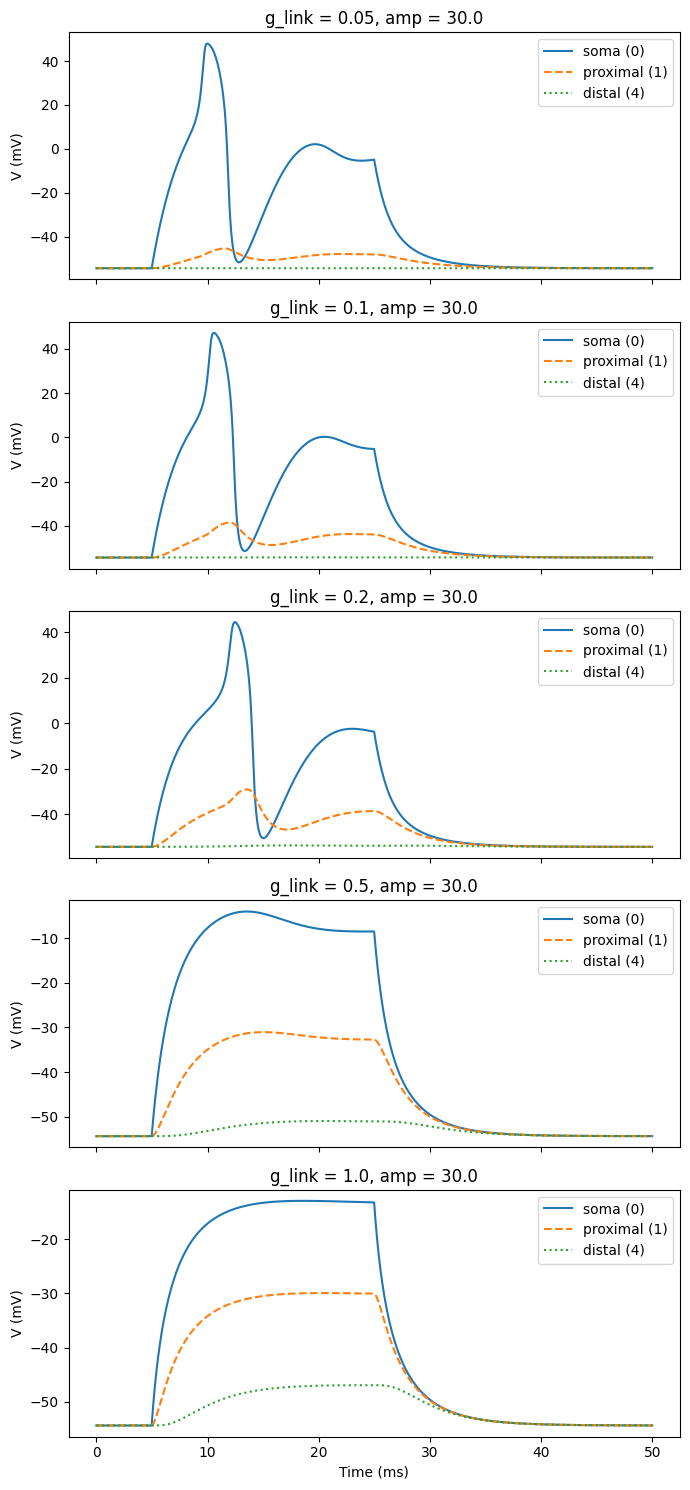

In [9]:
g_link_list = [0.05, 0.1, 0.2, 0.5, 1.0]
sweep_g_link(g_link_list, amp=30.0, N=N, dt_ms=dt, t_max_ms=t_max)

SWEEPS DONE

TRAIN

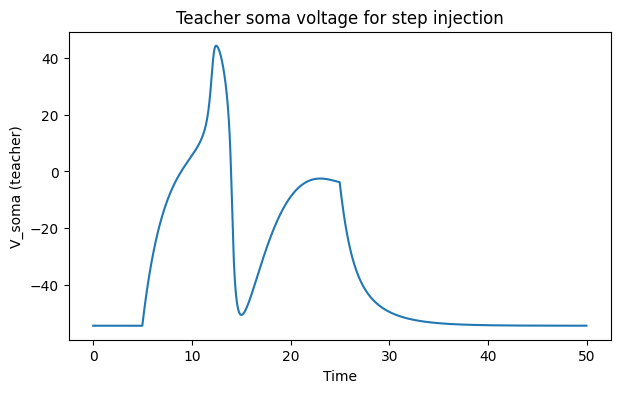

In [10]:
delay, dur, amp = 5.0, 20.0, 30.0
soma_idx = 0

I_teacher = make_step_injection(T, N, dt, soma_idx, delay, dur, amp)
V_teacher = model.simulate(phys_true, I_teacher, dt)  # (T, N)

time = jnp.arange(T) * dt
plt.figure(figsize=(7, 4))
plt.plot(time, V_teacher[:, soma_idx])
plt.xlabel("Time")
plt.ylabel("V_soma (teacher)")
plt.title("Teacher soma voltage for step injection")
plt.show()

In [11]:
from jax import tree_util

leaves, phys_treedef = tree_util.tree_flatten(phys_true)

phys_shapes = [p.shape for p in leaves]
phys_sizes = [p.size for p in leaves]
phys_idxs = [0]
for s in phys_sizes:
    phys_idxs.append(phys_idxs[-1] + s)

def phys_to_flat(phys_params):
    leaves, _ = tree_util.tree_flatten(phys_params)
    return jnp.concatenate([p.ravel() for p in leaves])

def flat_to_phys(flat_params):
    chunks = []
    for i in range(len(phys_sizes)):
        start = phys_idxs[i]
        end = phys_idxs[i+1]
        chunk = flat_params[start:end].reshape(phys_shapes[i])
        chunks.append(chunk)
    phys_list = tree_util.tree_unflatten(phys_treedef, chunks)
    return phys_list

flat_params_true = phys_to_flat(phys_true)
phys_recon = flat_to_phys(flat_params_true)

In [12]:
key_master, key_params_init = jax.random.split(key_master)
flat_params_init = flat_params_true + 0.1 * jax.random.normal(key_params_init, flat_params_true.shape)

In [13]:
def simulate_from_flat(flat_params, I_t, dt):
    phys_params = flat_to_phys(flat_params)
    return model.simulate(phys_params, I_t, dt)

def loss_fn(flat_params, I_t, V_target_soma, dt):
    V = simulate_from_flat(flat_params, I_t, dt)
    V_soma = V[:, soma_idx]
    return jnp.mean((V_soma - V_target_soma) ** 2)

loss_and_grad = jax.value_and_grad(loss_fn)
loss_and_grad_jit = jax.jit(loss_and_grad)


In [14]:
V_target_soma = V_teacher[:, soma_idx]

learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(flat_params_init)

flat_params = flat_params_init

num_steps = 500
print_every = 50

for step in range(num_steps + 1):
    loss_val, grad = loss_and_grad_jit(flat_params, I_teacher, V_target_soma, dt)
    updates, opt_state = optimizer.update(grad, opt_state, flat_params)
    flat_params = optax.apply_updates(flat_params, updates)

    if step % print_every == 0:
        gnorm = jnp.linalg.norm(grad)
        print(f"step {step:4d}  loss={loss_val:.3e}  |grad|={gnorm:.3e}")


step    0  loss=1.359e+02  |grad|=1.109e+03
step   50  loss=2.110e-01  |grad|=2.877e+02
step  100  loss=1.083e-01  |grad|=3.181e+01
step  150  loss=7.763e-02  |grad|=6.509e+00
step  200  loss=5.716e-02  |grad|=1.590e+00
step  250  loss=4.305e-02  |grad|=1.249e+00
step  300  loss=3.297e-02  |grad|=1.132e+00
step  350  loss=2.550e-02  |grad|=1.051e+00
step  400  loss=1.979e-02  |grad|=9.715e-01
step  450  loss=1.536e-02  |grad|=8.836e-01
step  500  loss=1.189e-02  |grad|=7.894e-01


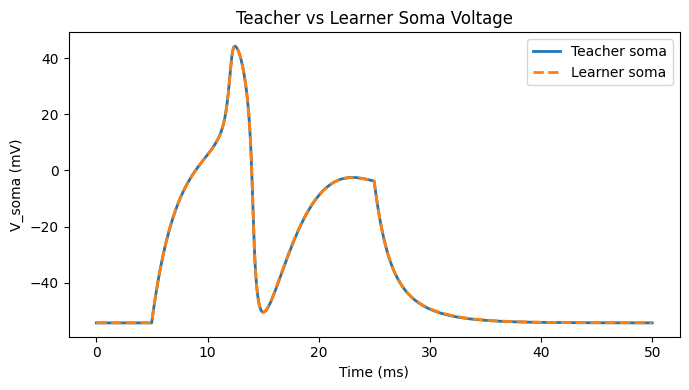

In [15]:
phys_learner = flat_to_phys(flat_params)
V_learner = model.simulate(phys_learner, I_teacher, dt)  # (T, N)

V_teacher_soma = V_teacher[:, soma_idx]
V_learner_soma = V_learner[:, soma_idx]

time_ms = jnp.arange(V_teacher.shape[0]) * dt
plt.figure(figsize=(7, 4))
plt.plot(time_ms, V_teacher_soma, label="Teacher soma", linewidth=2)
plt.plot(time_ms, V_learner_soma, "--", label="Learner soma", linewidth=2)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher vs Learner Soma Voltage")
plt.legend()
plt.tight_layout()
plt.show()



In [16]:
# Keys to inspect
param_keys = ["HH_gNa", "HH_gK", "HH_gL", "HH_ENa", "HH_EK", "HH_EL", "C_m"]

print("Parameter comparison (teacher vs learner):\n")
for name in param_keys:
    pt = phys_true[name]
    pl = phys_learner[name]
    diff = pl - pt

    print(f"{name}:")
    print(f"teacher:{pt}")
    print(f"learner:{pl}")
    print(f"diff:{diff}")
    print(f"mean |diff| = {jnp.mean(jnp.abs(diff)):.3e}")
    print()


Parameter comparison (teacher vs learner):

HH_gNa:
teacher:[120. 120. 120. 120. 120.]
learner:[120.08358519 119.7151978  120.02388839 120.05589833 119.97592465]
diff:[ 0.08358519 -0.2848022   0.02388839  0.05589833 -0.02407535]
mean |diff| = 9.445e-02

HH_gK:
teacher:[36. 36. 36. 36. 36.]
learner:[35.91849113 37.54891719 36.11289194 35.97194795 36.10718446]
diff:[-0.08150887  1.54891719  0.11289194 -0.02805205  0.10718446]
mean |diff| = 3.757e-01

HH_gL:
teacher:[0.3 0.3 0.3 0.3 0.3]
learner:[0.30323835 0.24296073 0.45834265 0.78499373 0.68551234]
diff:[ 0.00323835 -0.05703927  0.15834265  0.48499373  0.38551234]
mean |diff| = 2.178e-01

HH_ENa:
teacher:[50. 50. 50. 50. 50.]
learner:[50.00768336 49.80478174 50.14616414 50.1025252  50.05233145]
diff:[ 0.00768336 -0.19521826  0.14616414  0.1025252   0.05233145]
mean |diff| = 1.008e-01

HH_EK:
teacher:[-77. -77. -77. -77. -77.]
learner:[-77.04300371 -78.51636528 -77.16252937 -77.08447903 -77.0130082 ]
diff:[-0.04300371 -1.51636528 -0.162

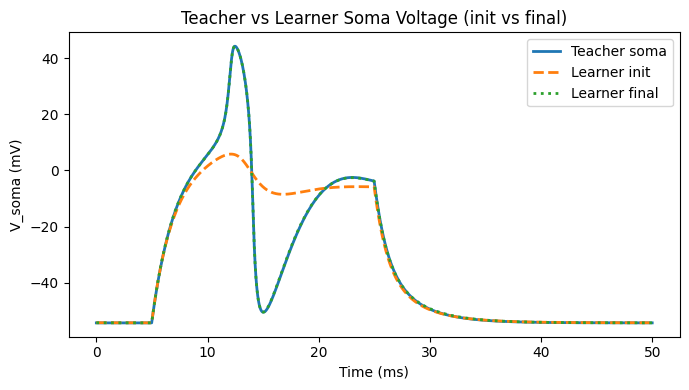

In [18]:
# initial learner (before training)
phys_init = flat_to_phys(flat_params_init)
V_init = model.simulate(phys_init, I_teacher, dt)
V_init_soma = V_init[:, soma_idx]

time_ms = jnp.arange(V_teacher.shape[0]) * dt

plt.figure(figsize=(7, 4))
plt.plot(time_ms, V_teacher_soma, label="Teacher soma", linewidth=2)
plt.plot(time_ms, V_init_soma, "--", label="Learner init", linewidth=2)
plt.plot(time_ms, V_learner_soma, ":", label="Learner final", linewidth=2)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher vs Learner Soma Voltage (init vs final)")
plt.legend()
plt.tight_layout()
plt.show()
